In [1]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
import pyntcloud
from pyntcloud import PyntCloud
import scipy
from sklearn.neighbors import NearestNeighbors
import src.realsense.dataset as rld
import src.realsense.camera as rlc
import src.visual3d.geometry as geom
import rosbag

print("Environment Ready")

# %matplotlib
%load_ext autoreload
%autoreload 2

Environment Ready


In [52]:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file("data/shadow_with_objects.bag")
profile = pipe.start(cfg)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(120):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")


Frames Captured


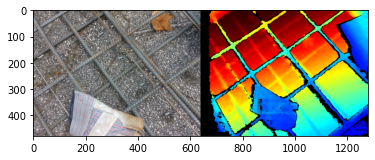

In [53]:
color = np.asanyarray(color_frame.get_data())
# plt.rcParams["axes.grid"] = False
# plt.rcParams['figure.figsize'] = [12, 6]
# plt.imshow(color)

colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
gray = np.mean(colorized_depth,axis=2).astype(np.uint8)
images = np.hstack((color,colorized_depth))
# plt.imshow(np.hstack((np.dstack((gray,gray,gray)),colorized_depth)))
plt.imshow(images)

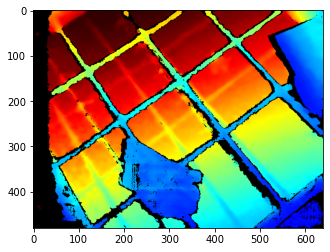

In [54]:
plt.imshow(colorized_depth)

0.0010000000474974513
Depth in meters :  [[0.01666667 0.01666667 0.01666667 ... 0.065      0.065      0.065     ]
 [0.01666667 0.01666667 0.01666667 ... 0.065      0.065      0.065     ]
 [0.01666667 0.01666667 0.01666667 ... 0.065      0.065      0.065     ]
 ...
 [0.16966667 0.16966667 0.16966667 ... 0.         0.         0.        ]
 [0.16966667 0.16966667 0.16966667 ... 0.         0.         0.        ]
 [0.16966667 0.16966667 0.16966667 ... 0.         0.         0.        ]]


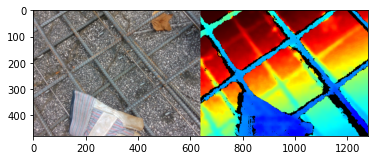

In [55]:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())


# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)
# plt.imshow(colorized_depth_cp)

depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
print(depth_scale)

depth = np.asanyarray(aligned_depth_frame.get_data())
# Crop depth data:

colorized_depth_meters = depth_scale * np.mean(colorized_depth, axis=2)
print("Depth in meters : ", colorized_depth_meters)



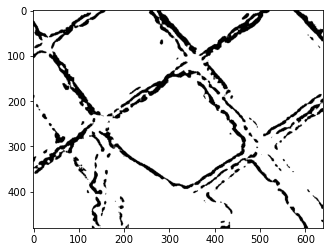

In [56]:
depth_blue = colorized_depth[:,:,:]/255.1
depth_blur = cv2.GaussianBlur(depth_blue,(9,9),cv2.BORDER_DEFAULT)

depth_laplacian = cv2.Laplacian(depth_blur,cv2.CV_64F)
depth_laplacian = (depth_laplacian - depth_laplacian.min())
depth_laplacian = depth_laplacian/depth_laplacian.max()
depth_laplacian_cp = np.ones_like(depth_laplacian)
depth_laplacian_cp[(depth_laplacian>0.55)&(depth_laplacian<1.1)]=0
# plt.imshow(depth_laplacian_cp)


# depth_laplacian_cp[(depth_laplacian>0.35)&(depth_laplacian<0.55)]=0
gray = np.mean(depth_laplacian_cp,axis=2)
gray = cv2.GaussianBlur(gray,(9,9),cv2.BORDER_DEFAULT)
gray = gray/gray.max()

gray_lowpass = cv2.GaussianBlur(gray,(9,9),cv2.BORDER_DEFAULT)
# gray = gray - gray_lowpass
gray = (gray-gray.min())/(gray.max()-gray.min())
th = 0.4
gray[gray>th]=255
gray[gray<th]=0
gray = gray.astype(np.uint8)
plt.imshow(gray,cmap=plt.cm.binary)
# plt.plot([0,600],[0,400],color='red')


459


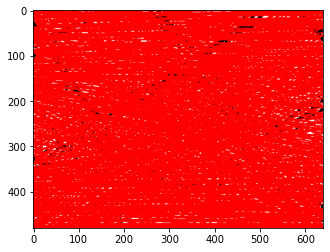

In [57]:
gray = 255-gray
lines = cv2.HoughLinesP(
            gray, # Input edge image
            5, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=400, # Min number of votes for valid line
            minLineLength=50, # Min allowed length of line
            maxLineGap=40 # Max allowed gap between line for joining them
            )
img = np.dstack((gray,gray,gray)).astype(np.uint8)

# img =colorized_depth
# Iterate over points
line_list = []
for points in lines:
    x1,y1,x2,y2=points[0]
    cv2.line(img,(x1,y1),(x2,y2),(255, 0, 0),2)
    line_list.append(([x1,y1],[x2,y2]))
plt.imshow(img)
num_lines = len(line_list)
print(num_lines)


233
121
66
38
24
17
13
11
10
10


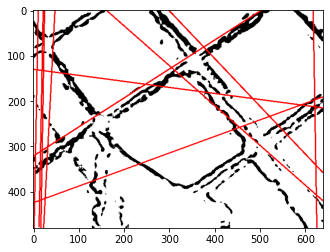

In [58]:
num_lines_prev = 0
while num_lines != num_lines_prev:
    visited = set()
    line_list_merged = []
    for i in range(num_lines):
        for j in range(i+1,num_lines):
            psi,pei = line_list[i]
            psj,pej = line_list[j]
            slope_i = (pei[1] - psi[1])/(pei[0]-psi[0])
            slope_j = (pej[1] - psj[1])/(pej[0]-psj[0])
            itcpt_i = pei[1]- slope_i*pei[0]
            itcpt_j = pej[1]- slope_j*pej[0]

            if (abs(slope_i-slope_j)<0.5) and (abs(itcpt_i-itcpt_j)<100) and (i not in visited) and (j not in visited):
                visited.add(i);visited.add(j)
                slope = (slope_i + slope_j)/2
                itcpt = (itcpt_i + itcpt_j)/2
                xmax = max(pei[0],psi[0],pej[0],psj[0])
                xmin = min(pei[0],psi[0],pej[0],psj[0])
                y_xmax = itcpt + slope * xmax
                y_xmin = itcpt + slope * xmin
                line_list_merged.append(([xmin,y_xmin],[xmax,y_xmax]))
    for i in range(num_lines):
        if i not in visited:
            line_list_merged.append(line_list[i])

    line_list = line_list_merged
    num_lines_prev = num_lines
    num_lines = len(line_list)
    
    print(num_lines)

img = np.dstack((gray,gray,gray)).astype(np.uint8)
for points in line_list:
    (x1,y1),(x2,y2)=points
    cv2.line(img,(int(x1),int(y1)),(int(x2),int(y2)),(255, 0, 0),2)

plt.imshow(img)


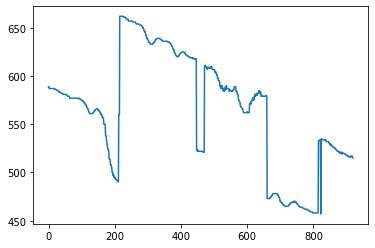

In [59]:
img = np.dstack((gray,gray,gray)).astype(np.uint8)
points = line_list[2]
(x1,y1),(x2,y2)=points
cv2.line(img,(int(x1),int(y1)),(int(x2),int(y2)),(255, 0, 0),2)

u = np.linspace(x1,x2,num=1000).astype(np.int)
v = np.linspace(y1,y2,num=1000).astype(np.int)
# depth = np.asanyarray(depth_frame.get_data())

d = depth[v,u]
plt.plot(d[d>0])

In [5]:
topics = ['/device_0/sensor_1/Color_0/info/camera_info']
bag = rosbag.Bag("data/second_two_layer.bag")

for topic, msg, t in bag.read_messages(topics):
    H = msg.height
    W = msg.width
    K = msg.K

K = np.array(K).reshape(3,3)
print(H,W)
xyz,rgb = rlc.project_rgbd2pd(color,depth,K)
pd = geom.PointCloud(xyz=xyz,color='blue')
pd.rgb = rgb

# rebar
one = np.ones(u.shape).astype(np.int)
uv1 = np.r_['0,2',u,v,one]
K_inv = np.linalg.inv(K)
d =d 
xyz = K_inv@uv1

lamb = d/xyz[2,:]
xyz[0,:] = lamb * xyz[0,:]
xyz[1,:] = lamb * xyz[1,:]
xyz[2,:] = d
xyz = xyz.T

pd_rebar = geom.PointCloud(xyz=xyz,color='green')
pd.add(pd_rebar)

# v = pd.show()
# v.set(point_size =1)

480 640


NameError: name 'color' is not defined